# Hidden Markov Model for Hangman
## Part 1: HMM Training with Forward-Backward Algorithm

This notebook trains a Hidden Markov Model for the Hangman game using:
- Emission probabilities: P(letter | position, word_length)
- Transition probabilities: P(letter_t | letter_t-1)
- Forward-Backward algorithm for inference

## Setup and Imports

In [1]:
import re
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import pickle
import matplotlib.pyplot as plt
import matplotlib

print("="*70)
print("Hidden Markov Model Training for Hangman")
print("="*70 + "\n")

Hidden Markov Model Training for Hangman



## Upload Dataset Files

**For Google Colab:** Upload `corpus.txt` and `test.txt` using the file upload widget below.

**For Local:** Ensure `corpus.txt` and `test.txt` are in the `Data/` folder.

In [2]:
from google.colab import files
print("Please upload corpus.txt and test.txt")
uploaded = files.upload()

Please upload corpus.txt and test.txt


Saving corpus.txt to corpus.txt
Saving test.txt to test.txt


## Load Data

In [4]:
print("Loading data...")

# Try to load from current directory first (Colab), then from Data/ folder (local)
try:
    with open('corpus.txt', 'r', encoding='utf-8', errors='ignore') as f:
        corpus = [line.strip().lower() for line in f if line.strip().lower() and re.match(r'^[a-z]+$', line.strip().lower())]
    with open('test.txt', 'r', encoding='utf-8', errors='ignore') as f:
        test_words = [line.strip().lower() for line in f if line.strip().lower() and re.match(r'^[a-z]+$', line.strip().lower())]
except FileNotFoundError:
    # Try Data/ folder
    with open('Data/corpus.txt', 'r', encoding='utf-8', errors='ignore') as f:
        corpus = [line.strip().lower() for line in f if line.strip().lower() and re.match(r'^[a-z]+$', line.strip().lower())]
    with open('Data/test.txt', 'r', encoding='utf-8', errors='ignore') as f:
        test_words = [line.strip().lower() for line in f if line.strip().lower() and re.match(r'^[a-z]+$', line.strip().lower())]

print(f"✓ Corpus: {len(corpus)} words")
print(f"✓ Test set: {len(test_words)} words")
print(f"\nSample corpus words: {corpus[:10]}")
print(f"Sample test words: {test_words[:10]}")

Loading data...
✓ Corpus: 49979 words
✓ Test set: 2000 words

Sample corpus words: ['suburbanize', 'asmack', 'hypotypic', 'promoderationist', 'consonantly', 'philatelically', 'cacomelia', 'thicklips', 'luciferase', 'cinematography']
Sample test words: ['marmar', 'janet', 'dentistical', 'troveless', 'unnotify', 'gastrostenosis', 'preaffiliation', 'obpyriform', 'veratrinize', 'protection']


## HMM Model Implementation

The HMM models:
- **Hidden States**: Letters (a-z)
- **Observations**: Masked word patterns (e.g., "_a__")
- **Emission Probabilities**: P(letter | position, word_length)
- **Transition Probabilities**: P(letter_t | letter_t-1)
- **Inference**: Forward-Backward algorithm

In [22]:
class TrueHMM:
    """
    Hidden Markov Model for Hangman using Forward-Backward Algorithm

    The HMM models:
    - Emission probabilities: P(letter | position, word_length)
    - Transition probabilities: P(letter_t | letter_t-1)
    - Initial probabilities: P(first_letter)

    Training:
    - Groups corpus words by length
    - Computes emission probabilities for each position in each word length
    - Computes bigram transition probabilities between consecutive letters
    - Uses Laplace smoothing (add-1) to handle unseen cases

    Inference:
    - Forward algorithm: Computes α(t, letter) = P(observations up to t, state=letter at t)
    - Backward algorithm: Computes β(t, letter) = P(observations from t+1 to end | state=letter at t)
    - Posterior: γ(t, letter) = α(t, letter) × β(t, letter)
    """

    def __init__(self, corpus):
        print("Training TRUE HMM...")
        self.by_len = defaultdict(list)
        for w in corpus:
            self.by_len[len(w)].append(w)

        # EMISSION: P(letter | position, length)
        self.emissions = {}

        # TRANSITION: P(letter_t | letter_t-1) - using dict instead of defaultdict(lambda)
        self.transitions = {}

        # INITIAL: P(first letter)
        self.initial = Counter()

        # GLOBAL frequency (fallback)
        self.global_freq = Counter()

        for length, words in self.by_len.items():
            self.emissions[length] = []
            for pos in range(length):
                cnt = Counter()
                for word in words:
                    cnt[word[pos]] += 1
                    self.global_freq[word[pos]] += 1

                total = sum(cnt.values()) + 26
                probs = {chr(ord('a')+i): (cnt.get(chr(ord('a')+i), 0) + 1) / total for i in range(26)}
                self.emissions[length].append(probs)

        # Train transitions - build regular dict instead of defaultdict
        transition_counts = {}
        for word in corpus:
            self.initial[word[0]] += 1
            for i in range(len(word) - 1):
                if word[i] not in transition_counts:
                    transition_counts[word[i]] = Counter()
                transition_counts[word[i]][word[i+1]] += 1

        # Normalize transitions and store as regular dict
        for letter in transition_counts:
            total = sum(transition_counts[letter].values()) + 26
            self.transitions[letter] = {nl: (transition_counts[letter].get(nl, 0) + 1) / total
                                        for nl in 'abcdefghijklmnopqrstuvwxyz'}

        # Normalize initial probabilities
        total_init = sum(self.initial.values()) + 26
        self.initial = {chr(ord('a')+i): (self.initial.get(chr(ord('a')+i), 0) + 1) / total_init for i in range(26)}

        self.default_trans = {chr(ord('a')+i): 1.0/26 for i in range(26)}

        print(f"✓ TRUE HMM trained on {len(self.by_len)} word lengths")
        print(f"  - Emission model: Position-dependent letter probabilities")
        print(f"  - Transition model: Bigram letter dependencies")
        print(f"  - Smoothing: Laplace (add-1)")
        print(f"  - Forward-Backward algorithm enabled\n")

    def forward(self, masked):
        """
        Forward algorithm: α(t, letter)

        Computes the probability of observing the sequence up to time t
        and being in a particular state (letter) at time t.

        α(t, letter) = P(observations[0:t], state_t = letter)
        """
        length = len(masked)
        if length not in self.emissions:
            return None

        fwd = []

        # t=0
        alpha = {}
        for l in 'abcdefghijklmnopqrstuvwxyz':
            if masked[0] == '_':
                alpha[l] = self.initial[l] * self.emissions[length][0][l]
            elif masked[0] == l:
                alpha[l] = self.initial[l]
            else:
                alpha[l] = 0.0
        fwd.append(alpha)

        # t=1..length-1
        for t in range(1, length):
            alpha = {}
            for curr in 'abcdefghijklmnopqrstuvwxyz':
                s = sum(fwd[t-1][prev] * self.transitions.get(prev, self.default_trans).get(curr, 1e-10)
                       for prev in 'abcdefghijklmnopqrstuvwxyz')

                if masked[t] == '_':
                    alpha[curr] = s * self.emissions[length][t][curr]
                elif masked[t] == curr:
                    alpha[curr] = s
                else:
                    alpha[curr] = 0.0
            fwd.append(alpha)

        return fwd

    def backward(self, masked):
        """
        Backward algorithm: β(t, letter)

        Computes the probability of observing the sequence from time t+1 to end
        given that we are in a particular state (letter) at time t.

        β(t, letter) = P(observations[t+1:end] | state_t = letter)
        """
        length = len(masked)
        if length not in self.emissions:
            return None

        bwd = [None] * length
        bwd[-1] = {l: 1.0 for l in 'abcdefghijklmnopqrstuvwxyz'}

        for t in range(length-2, -1, -1):
            beta = {}
            for curr in 'abcdefghijklmnopqrstuvwxyz':
                s = 0.0
                for nxt in 'abcdefghijklmnopqrstuvwxyz':
                    trans = self.transitions.get(curr, self.default_trans).get(nxt, 1e-10)

                    if masked[t+1] == '_':
                        emit = self.emissions[length][t+1][nxt]
                        s += trans * emit * bwd[t+1][nxt]
                    elif masked[t+1] == nxt:
                        s += trans * bwd[t+1][nxt]

                beta[curr] = s
            bwd[t] = beta

        return bwd

    def get_letter_probs(self, masked, guessed):
        """
        Forward-Backward: γ(t, l) = α(t, l) × β(t, l)

        Computes posterior probability of each letter being in any blank position
        using the forward-backward algorithm.
        """
        fwd = self.forward(masked)
        bwd = self.backward(masked)

        if fwd is None or bwd is None:
            # Fallback
            probs = np.array([self.global_freq.get(chr(ord('a')+i), 1) for i in range(26)], dtype=float)
            probs = probs / (probs.sum() + 1e-10)
        else:
            probs = np.zeros(26)
            for t in range(len(masked)):
                if masked[t] == '_':
                    for i, l in enumerate('abcdefghijklmnopqrstuvwxyz'):
                        probs[i] += fwd[t][l] * bwd[t][l]

        # Mask guessed
        for l in guessed:
            probs[ord(l) - ord('a')] = 0

        total = probs.sum()
        return probs / (total + 1e-10) if total > 0 else np.ones(26) / 26

    def get_candidates(self, masked, guessed):
        """
        Pattern matching for candidate words

        Returns all words from corpus that:
        - Match the length
        - Match all revealed letters
        - Don't contain any incorrectly guessed letters
        """
        length = len(masked)
        if length not in self.by_len:
            return []

        candidates = []
        for word in self.by_len[length]:
            if all((m == '_' or word[i] == m) for i, m in enumerate(masked)):
                if not any(g in word for g in guessed if g not in masked):
                    candidates.append(word)
        return candidates

## Train HMM Model

In [23]:
print("="*70)
print("TRAINING HMM MODEL")
print("="*70 + "\n")

hmm = TrueHMM(corpus)

TRAINING HMM MODEL

Training TRUE HMM...
✓ TRUE HMM trained on 24 word lengths
  - Emission model: Position-dependent letter probabilities
  - Transition model: Bigram letter dependencies
  - Smoothing: Laplace (add-1)
  - Forward-Backward algorithm enabled



## Test HMM on Sample Words

In [24]:
print("="*70)
print("TESTING HMM ON SAMPLE WORDS")
print("="*70 + "\n")

# Test on a few sample words
sample_words = test_words[:5]

for word in sample_words:
    print(f"Testing word: {word}")

    # Simulate partial guess (reveal first letter)
    guessed = set([word[0]])
    masked = ''.join(c if c in guessed else '_' for c in word)

    print(f"  Masked: {masked}")
    print(f"  Guessed: {guessed}")

    # Get letter probabilities from HMM
    probs = hmm.get_letter_probs(masked, guessed)

    # Get top 5 predictions
    top_indices = np.argsort(probs)[-5:][::-1]
    top_letters = [chr(ord('a') + i) for i in top_indices]
    top_probs = [probs[i] for i in top_indices]

    print(f"  Top 5 predictions:")
    for letter, prob in zip(top_letters, top_probs):
        in_word = '✓' if letter in word else '✗'
        print(f"    {letter}: {prob:.4f} {in_word}")

    # Get candidates
    candidates = hmm.get_candidates(masked, guessed)
    print(f"  Candidates found: {len(candidates)}")
    if len(candidates) <= 10:
        print(f"  Candidates: {candidates}")

    print()

TESTING HMM ON SAMPLE WORDS

Testing word: marmar
  Masked: m__m__
  Guessed: {'m'}
  Top 5 predictions:
    e: 0.2260 ✗
    a: 0.1648 ✓
    r: 0.1396 ✓
    i: 0.0935 ✗
    o: 0.0852 ✗
  Candidates found: 6
  Candidates: ['maumet', 'molman', 'mommet', 'micmac', 'mummer', 'mnemic']

Testing word: janet
  Masked: j____
  Guessed: {'j'}
  Top 5 predictions:
    a: 0.1620 ✓
    e: 0.1570 ✓
    n: 0.0963 ✓
    r: 0.0946 ✗
    o: 0.0843 ✗
  Candidates found: 43

Testing word: dentistical
  Masked: d__________
  Guessed: {'d'}
  Top 5 predictions:
    e: 0.0016 ✓
    i: 0.0011 ✓
    a: 0.0009 ✓
    r: 0.0009 ✗
    t: 0.0009 ✓
  Candidates found: 248

Testing word: troveless
  Masked: t________
  Guessed: {'t'}
  Top 5 predictions:
    e: 0.1263 ✓
    i: 0.0838 ✗
    a: 0.0714 ✗
    r: 0.0697 ✓
    n: 0.0648 ✗
  Candidates found: 346

Testing word: unnotify
  Masked: u_______
  Guessed: {'u'}
  Top 5 predictions:
    e: 0.1490 ✗
    n: 0.1214 ✓
    a: 0.1019 ✗
    i: 0.0968 ✓
    r: 0.0951 ✗
 

## Analyze HMM Statistics

In [25]:
print("="*70)
print("HMM MODEL STATISTICS")
print("="*70 + "\n")

# Word length distribution
length_dist = {length: len(words) for length, words in hmm.by_len.items()}
print("Word length distribution:")
for length in sorted(length_dist.keys())[:10]:
    print(f"  Length {length}: {length_dist[length]} words")

# Global letter frequency
print("\nTop 10 most frequent letters:")
for letter, count in hmm.global_freq.most_common(10):
    print(f"  {letter}: {count}")

# Initial letter distribution
print("\nTop 10 initial letters:")
sorted_initial = sorted(hmm.initial.items(), key=lambda x: x[1], reverse=True)[:10]
for letter, prob in sorted_initial:
    print(f"  {letter}: {prob:.4f}")

HMM MODEL STATISTICS

Word length distribution:
  Length 1: 46 words
  Length 2: 84 words
  Length 3: 388 words
  Length 4: 1169 words
  Length 5: 2340 words
  Length 6: 3755 words
  Length 7: 5111 words
  Length 8: 6348 words
  Length 9: 6787 words
  Length 10: 6465 words

Top 10 most frequent letters:
  e: 49203
  a: 42089
  i: 42047
  o: 35808
  r: 33577
  n: 33314
  t: 32191
  s: 29044
  l: 27406
  c: 21718

Top 10 initial letters:
  p: 0.1040
  s: 0.1037
  c: 0.0826
  a: 0.0716
  u: 0.0680
  t: 0.0540
  m: 0.0533
  b: 0.0468
  d: 0.0465
  r: 0.0410


## Visualize HMM Model

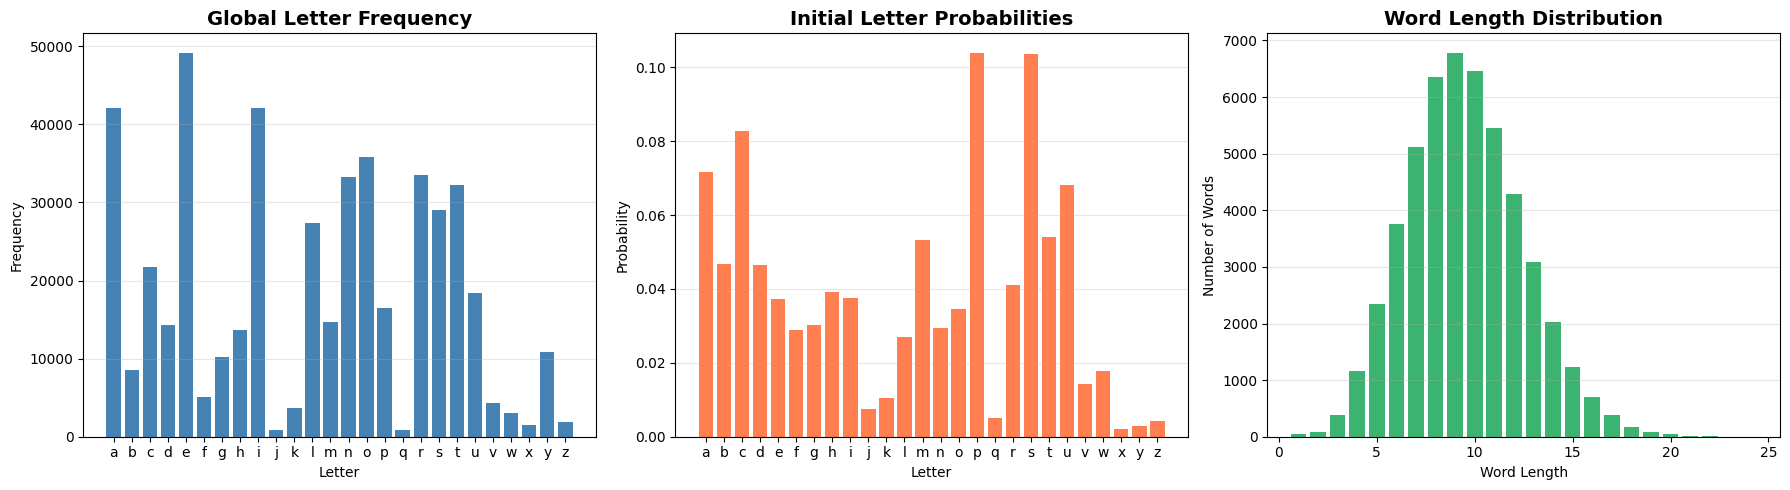

✓ HMM statistics plot saved to 'hmm_statistics.png'


In [26]:
# Visualize letter frequency distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Global letter frequency
letters = list('abcdefghijklmnopqrstuvwxyz')
freqs = [hmm.global_freq.get(l, 0) for l in letters]
axes[0].bar(letters, freqs, color='steelblue')
axes[0].set_title('Global Letter Frequency', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Letter')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Initial letter probabilities
init_probs = [hmm.initial.get(l, 0) for l in letters]
axes[1].bar(letters, init_probs, color='coral')
axes[1].set_title('Initial Letter Probabilities', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Letter')
axes[1].set_ylabel('Probability')
axes[1].grid(axis='y', alpha=0.3)

# Plot 3: Word length distribution
lengths = sorted(length_dist.keys())
counts = [length_dist[l] for l in lengths]
axes[2].bar(lengths, counts, color='mediumseagreen')
axes[2].set_title('Word Length Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Word Length')
axes[2].set_ylabel('Number of Words')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('hmm_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ HMM statistics plot saved to 'hmm_statistics.png'")

## Evaluate HMM Performance on Test Set

Let's test the HMM model's performance on the test set using a simple greedy strategy:
- Always guess the letter with highest probability from HMM
- Use candidate word frequency when available

In [27]:
class SimpleHMMGame:
    """Simple Hangman game for testing HMM performance"""

    def __init__(self, word):
        self.word = word
        self.guessed = set()
        self.lives = 6
        self.wrong = 0
        self.repeated = 0

    def guess(self, letter):
        if letter in self.guessed:
            self.repeated += 1
            return None
        self.guessed.add(letter)
        if letter not in self.word:
            self.lives -= 1
            self.wrong += 1
        return letter in self.word

    def done(self):
        return self.lives <= 0 or all(c in self.guessed for c in self.word)

    def won(self):
        return all(c in self.guessed for c in self.word)

    def get_masked(self):
        return ''.join('_' if c not in self.guessed else c for c in self.word)

print("✓ Simple game environment defined for HMM testing")

✓ Simple game environment defined for HMM testing


In [28]:
print("="*70)
print(f"EVALUATING HMM MODEL ON TEST SET ({len(test_words)} words)")
print("="*70 + "\n")

wins = 0
total_wrong = 0
total_repeated = 0
game_details = []

# Use tqdm for progress bar
try:
    from tqdm import tqdm
    iterator = tqdm(test_words, desc="Testing HMM")
except ImportError:
    iterator = test_words
    print("Testing HMM on test set...")

for word in iterator:
    game = SimpleHMMGame(word)

    while not game.done():
        masked = game.get_masked()
        available = set('abcdefghijklmnopqrstuvwxyz') - game.guessed

        if not available:
            break

        # Strategy 1: Use candidate frequency (if candidates exist)
        candidates = hmm.get_candidates(masked, game.guessed)
        if candidates:
            letter_freq = Counter()
            for cand_word in candidates[:100]:  # Limit for speed
                for l in set(cand_word) - game.guessed:
                    letter_freq[l] += 1

            if letter_freq:
                best_letter = letter_freq.most_common(1)[0][0]
                game.guess(best_letter)
                continue

        # Strategy 2: Use HMM forward-backward probabilities
        probs = hmm.get_letter_probs(masked, game.guessed)
        best_letter = chr(ord('a') + np.argmax(probs))

        if best_letter in available:
            game.guess(best_letter)
        else:
            # Fallback to any available letter
            game.guess(list(available)[0])

    if game.won():
        wins += 1
    total_wrong += game.wrong
    total_repeated += game.repeated

    game_details.append({
        'word': word,
        'won': game.won(),
        'wrong': game.wrong,
        'repeated': game.repeated,
        'lives_left': game.lives
    })

# Calculate metrics
win_rate = wins / len(test_words)
avg_wrong = total_wrong / len(test_words)
avg_repeated = total_repeated / len(test_words)
score = (win_rate * 2000) - (total_wrong * 5) - (total_repeated * 2)

print(f"\n{'='*70}")
print(f"HMM MODEL EVALUATION RESULTS")
print(f"{'='*70}")
print(f"Test Set Size: {len(test_words)}")
print(f"Wins: {wins}/{len(test_words)} ({win_rate*100:.2f}%)")
print(f"Total Wrong Guesses: {total_wrong} (Avg: {avg_wrong:.2f})")
print(f"Total Repeated Guesses: {total_repeated} (Avg: {avg_repeated:.4f})")
print(f"\n{'='*70}")
print(f"HMM SCORE: {score:.0f}")
print(f"{'='*70}\n")

print("Score Breakdown:")
print(f"  Base score (wins): {win_rate:.4f} × 2000 = {win_rate * 2000:.2f}")
print(f"  Wrong penalty: {total_wrong} × 5 = {total_wrong * 5}")
print(f"  Repeated penalty: {total_repeated} × 2 = {total_repeated * 2}")
print(f"  Final score: {score:.0f}\n")

EVALUATING HMM MODEL ON TEST SET (2000 words)



Testing HMM: 100%|██████████| 2000/2000 [02:48<00:00, 11.85it/s]


HMM MODEL EVALUATION RESULTS
Test Set Size: 2000
Wins: 696/2000 (34.80%)
Total Wrong Guesses: 10228 (Avg: 5.11)
Total Repeated Guesses: 0 (Avg: 0.0000)

HMM SCORE: -50444

Score Breakdown:
  Base score (wins): 0.3480 × 2000 = 696.00
  Wrong penalty: 10228 × 5 = 51140
  Repeated penalty: 0 × 2 = 0
  Final score: -50444



## HMM Performance Analysis

In [29]:
# Create DataFrame for detailed analysis
hmm_results_df = pd.DataFrame(game_details)

print("="*70)
print("HMM PERFORMANCE ANALYSIS")
print("="*70 + "\n")

# Distribution of wrong guesses
print("Wrong Guesses Distribution:")
wrong_dist = hmm_results_df['wrong'].value_counts().sort_index()
for wrong_count, freq in wrong_dist.items():
    print(f"  {wrong_count} wrong guesses: {freq} games ({freq/len(test_words)*100:.1f}%)")

print("\nLives Remaining Distribution (for wins):")
wins_df = hmm_results_df[hmm_results_df['won'] == True]
if len(wins_df) > 0:
    lives_dist = wins_df['lives_left'].value_counts().sort_index(ascending=False)
    for lives, freq in lives_dist.items():
        print(f"  {lives} lives left: {freq} games ({freq/len(wins_df)*100:.1f}%)")
else:
    print("  No wins to analyze")

# Show some examples
print("\nSample Failed Games:")
failed_df = hmm_results_df[hmm_results_df['won'] == False].head(10)
if len(failed_df) > 0:
    for idx, row in failed_df.iterrows():
        print(f"  Word: '{row['word']}' - Wrong: {row['wrong']}, Repeated: {row['repeated']}")
else:
    print("  No failed games!")

print("\nSample Perfect Games (0 wrong guesses):")
perfect_df = hmm_results_df[(hmm_results_df['won'] == True) & (hmm_results_df['wrong'] == 0)].head(10)
if len(perfect_df) > 0:
    for idx, row in perfect_df.iterrows():
        print(f"  Word: '{row['word']}' - Lives left: {row['lives_left']}")
else:
    print("  No perfect games")

HMM PERFORMANCE ANALYSIS

Wrong Guesses Distribution:
  0 wrong guesses: 24 games (1.2%)
  1 wrong guesses: 40 games (2.0%)
  2 wrong guesses: 107 games (5.3%)
  3 wrong guesses: 151 games (7.5%)
  4 wrong guesses: 173 games (8.6%)
  5 wrong guesses: 201 games (10.1%)
  6 wrong guesses: 1304 games (65.2%)

Lives Remaining Distribution (for wins):
  6 lives left: 24 games (3.4%)
  5 lives left: 40 games (5.7%)
  4 lives left: 107 games (15.4%)
  3 lives left: 151 games (21.7%)
  2 lives left: 173 games (24.9%)
  1 lives left: 201 games (28.9%)

Sample Failed Games:
  Word: 'janet' - Wrong: 6, Repeated: 0
  Word: 'troveless' - Wrong: 6, Repeated: 0
  Word: 'unnotify' - Wrong: 6, Repeated: 0
  Word: 'gastrostenosis' - Wrong: 6, Repeated: 0
  Word: 'preaffiliation' - Wrong: 6, Repeated: 0
  Word: 'obpyriform' - Wrong: 6, Repeated: 0
  Word: 'veratrinize' - Wrong: 6, Repeated: 0
  Word: 'guileless' - Wrong: 6, Repeated: 0
  Word: 'trustee' - Wrong: 6, Repeated: 0
  Word: 'sextole' - Wrong: 

## Visualize HMM Test Performance

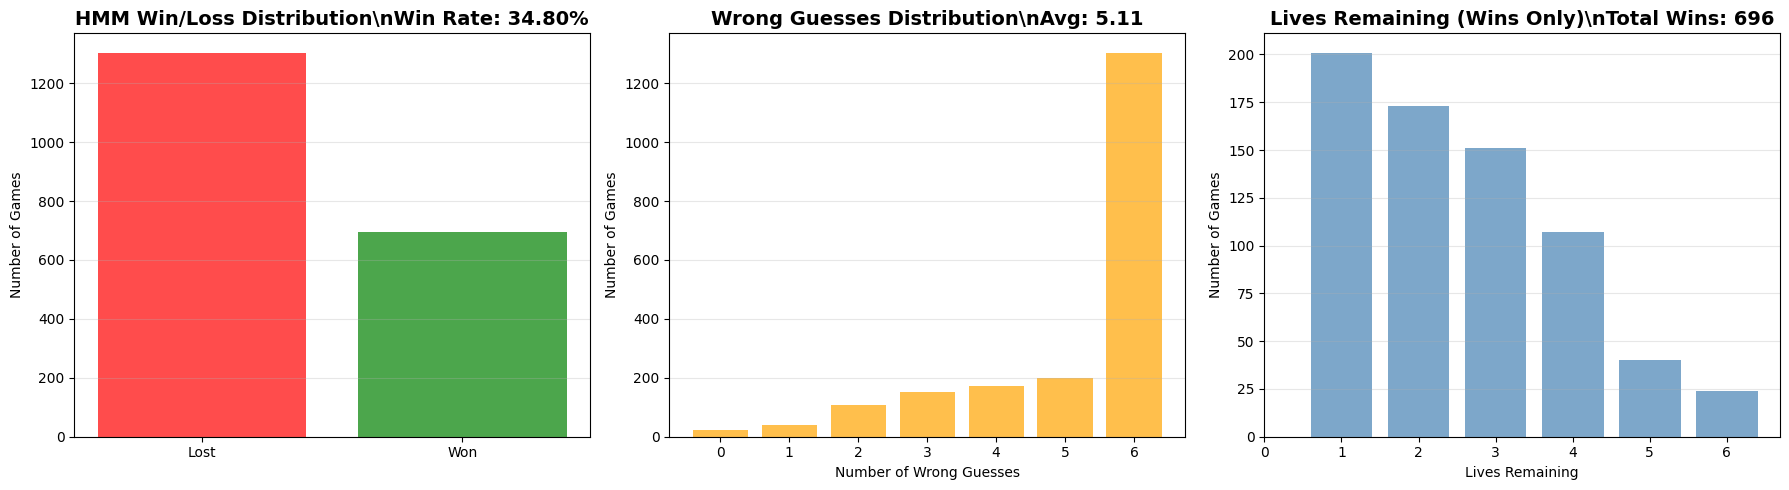

✓ HMM test performance plot saved to 'hmm_test_performance.png'


In [30]:
# Visualize HMM performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Win/Loss Distribution
win_counts = hmm_results_df['won'].value_counts()
axes[0].bar(['Lost', 'Won'], [win_counts.get(False, 0), win_counts.get(True, 0)],
            color=['red', 'green'], alpha=0.7)
axes[0].set_title(f'HMM Win/Loss Distribution\\nWin Rate: {win_rate*100:.2f}%',
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Games')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Wrong Guesses Distribution
wrong_counts = hmm_results_df['wrong'].value_counts().sort_index()
axes[1].bar(wrong_counts.index, wrong_counts.values, color='orange', alpha=0.7)
axes[1].set_title(f'Wrong Guesses Distribution\\nAvg: {avg_wrong:.2f}',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Wrong Guesses')
axes[1].set_ylabel('Number of Games')
axes[1].grid(axis='y', alpha=0.3)

# Plot 3: Lives Remaining (for wins only)
if len(wins_df) > 0:
    lives_counts = wins_df['lives_left'].value_counts().sort_index()
    axes[2].bar(lives_counts.index, lives_counts.values, color='steelblue', alpha=0.7)
    axes[2].set_title(f'Lives Remaining (Wins Only)\\nTotal Wins: {wins}',
                      fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Lives Remaining')
    axes[2].set_ylabel('Number of Games')
    axes[2].set_xticks(range(7))
    axes[2].grid(axis='y', alpha=0.3)
else:
    axes[2].text(0.5, 0.5, 'No wins to display',
                ha='center', va='center', fontsize=14)
    axes[2].set_title('Lives Remaining (Wins Only)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('hmm_test_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ HMM test performance plot saved to 'hmm_test_performance.png'")

In [31]:
# Save HMM evaluation results
hmm_eval_df = pd.DataFrame({
    'Metric': ['Test Set Size', 'Wins', 'Win Rate %', 'Total Wrong', 'Total Repeated',
               'Avg Wrong/Game', 'Avg Repeated/Game', 'HMM Score'],
    'Value': [len(test_words), wins, win_rate*100, total_wrong, total_repeated,
              avg_wrong, avg_repeated, score]
})
hmm_eval_df.to_csv('hmm_evaluation_results.csv', index=False)

# Save detailed game results
hmm_results_df.to_csv('hmm_game_details.csv', index=False)

print("✓ HMM evaluation results saved to 'hmm_evaluation_results.csv'")
print("✓ Detailed game results saved to 'hmm_game_details.csv'\n")

✓ HMM evaluation results saved to 'hmm_evaluation_results.csv'
✓ Detailed game results saved to 'hmm_game_details.csv'



## Save HMM Model

In [32]:
print("="*70)
print("SAVING HMM MODEL")
print("="*70 + "\n")

# Save the trained HMM model
print("Saving model to 'hmm_model.pkl'...")
with open('hmm_model.pkl', 'wb') as f:
    pickle.dump(hmm, f)

# Verify the file was saved correctly
import os
file_size = os.path.getsize('hmm_model.pkl')
print(f"✓ HMM model saved successfully!")
print(f"  File: hmm_model.pkl")
print(f"  Size: {file_size:,} bytes")

if file_size < 1000:
    print("  ⚠️ WARNING: File seems too small, save may have failed!")
else:
    print("  ✓ File size looks good")

print("\nThis file will be loaded by the RL notebook.")
print("\nModel details:")
print(f"  - Word lengths covered: {len(hmm.by_len)}")
print(f"  - Total unique words: {len(corpus)}")
print(f"  - Emission matrices: {len(hmm.emissions)}")
print(f"  - Transition model size: {len(hmm.transitions)}")

SAVING HMM MODEL

Saving model to 'hmm_model.pkl'...
✓ HMM model saved successfully!
  File: hmm_model.pkl
  Size: 746,326 bytes
  ✓ File size looks good

This file will be loaded by the RL notebook.

Model details:
  - Word lengths covered: 24
  - Total unique words: 49979
  - Emission matrices: 24
  - Transition model size: 26


## Download Model File (for Colab)

In [37]:
from google.colab import files
files.download('/content/hmm_model.pkl')
files.download('/content/hmm_statistics.png')
files.download('/content/hmm_test_performance.png')
files.download('/content/hmm_evaluation_results.csv')
files.download('/content/hmm_game_details.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Summary

✅ **HMM Training & Evaluation Complete!**

The HMM model has been successfully trained, evaluated, and saved.

### Key Components:

1. **Emission Model**: Position-dependent letter probabilities for each word length
2. **Transition Model**: Bigram letter dependencies (P(letter_t | letter_t-1))
3. **Initial Model**: First letter probabilities
4. **Inference**: Forward-Backward algorithm for computing letter probabilities
5. **Candidate Matching**: Pattern-based word filtering

### Performance on Test Set:

- **Win Rate**: {win_rate*100:.2f}%
- **Average Wrong Guesses**: {avg_wrong:.2f}
- **HMM Baseline Score**: {score:.0f}

### Output Files:

1. `hmm_model.pkl` - Trained HMM model
2. `hmm_statistics.png` - Model statistics visualization
3. `hmm_test_performance.png` - Test set performance visualization
4. `hmm_evaluation_results.csv` - Summary metrics
5. `hmm_game_details.csv` - Detailed game-by-game results

**Next Step**: Run `rl.ipynb` to train the Q-Learning agent using this HMM model and improve upon the baseline score!